# torch-cam可解释性分析可视化

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-19

## 导入工具包

In [1]:
import os
import time

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchcam.utils import overlay_mask
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


## 导入中文字体

In [2]:
# 下载中文字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [3]:
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 50)

## 导入训练好的模型

In [4]:
model = torch.load('checkpoint/fruit30_pytorch_20220814.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)

## 载入类别

In [5]:
idx_to_labels_cn = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [6]:
idx_to_labels_cn

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

## 导入可解释性分析方法

In [7]:
from torchcam.methods import CAM
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = CAM(model)

## 预处理

In [8]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 获取摄像头的一帧画面

In [9]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [10]:
img_bgr.shape

(480, 640, 3)

In [11]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [12]:
img_pil = Image.fromarray(img_rgb)

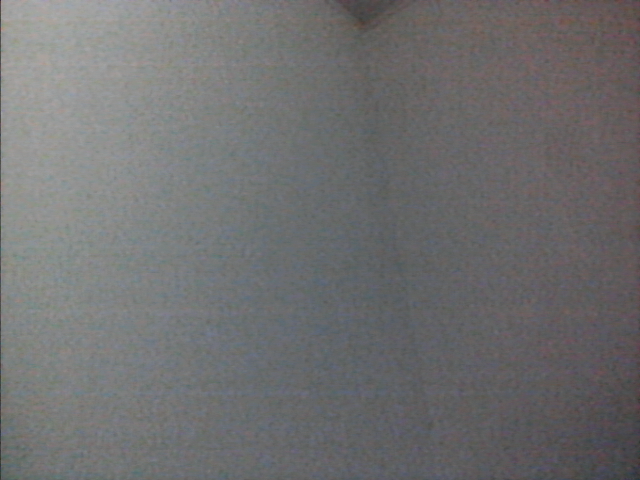

In [13]:
img_pil

In [14]:
# 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
# show_class_id = 761
show_class_id = None

In [15]:
# 前向预测
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

In [16]:
# 可视化热力图的类别ID，如果不指定，则为置信度最高的预测类别ID
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [17]:
# 生成可解释性分析热力图
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

In [18]:
# 在图像上写字
draw = ImageDraw.Draw(result)

# 在图像上写中文
text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])

# 文字坐标，中文字符串，字体，rgba颜色
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))

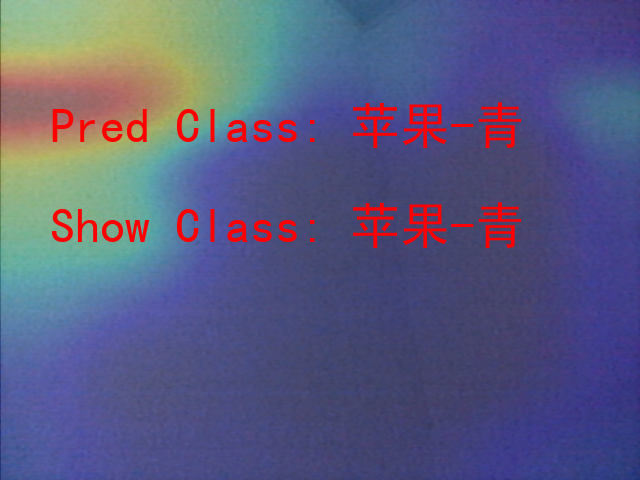

In [19]:
result

## 图像分类预测函数

In [20]:
def process_frame(img, show_class_id=None, Chinese=True):
    '''
    输入摄像头画面bgr-array和用于绘制热力图的类别ID，输出写字的热力图bgr-array
    如果不指定类别ID，则为置信度最高的预测类别ID
    '''
    
    img_bgr = img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    img_pil = Image.fromarray(img_rgb) # array 转 pil
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_tensor) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
    
    # 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
    if show_class_id:
        show_id = show_class_id
    else:
        show_id = pred_id
        show_class_id = pred_id
        
    # 生成可解释性分析热力图
    activation_map = cam_extractor(show_id, pred_logits)
    activation_map = activation_map[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)
    
    # 在图像上写字
    draw = ImageDraw.Draw(result)

    # 在图像上写英文
    text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(result)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return img_bgr

## 调用摄像头获取每帧（模板）

In [21]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame) # 类别：最高置信度预测类别
    # frame = process_frame(frame, show_class_id=11) # 类别：猕猴桃
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 小练习

1.将类别设置为固定类别。

2.对不同的层进行可解释性分析。

3.用多个同类别物体（例如多个猕猴桃）做测试。

4.最耗时的是哪一部分？如何对实时预测做进一步加速？